In [1]:
# Data Processing
import numpy as np
import pandas as pd
import re

# Word2Vec Library
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


# Dataset Cleaning

Not much needs to be done to this dataset to get it up to speed for testing and training. For the unlabelled data, we will first tokenize each review to split the sentences into meaningful word-like chunks. On the resulting tokens, we will then encode our information so that we may use it with the nn.Embedding function in pytorch.

On our labels, we will simply convert the positive/negative to 1/0, giving us nice numerical data to work with.

In [2]:
path = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

df = pd.read_csv(path)
df['sentiment'] = df['sentiment'].replace('positive', 1).replace('negative', 0)

remove_html = lambda x : re.sub(r'<.*?>', '', x).lower()
df['review'] = df['review'].str.strip() # remove leading/trailing whitespace
df['review'] = df['review'].apply(remove_html)
df.head()

/tmp/ipykernel_55/1120120182.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace('positive', 1).replace('negative', 0)


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


This class will allow us to batch our data for more efficient model training.

In [3]:
memo = {}
vocab_size = 0
def sentence_to_number(token_sentence):
    # algorithm to one-hot-encode all tokens
    global vocab_size
    output = []
    for word in token_sentence:
        if word in memo.keys():
            output.append(memo[word])
        else:
            vocab_size = vocab_size + 1
            memo[word] = vocab_size
            output.append(vocab_size)
    return output

df['tokenizedReview'] = df['review'].apply(word_tokenize)
df['tokenizedReview'] = df['tokenizedReview'].apply(sentence_to_number)
df.to_csv('/kaggle/working/cleaned_data.csv')

# LSTM Network

We shall attempt to create a LSTM neural network to classify our IMDB reviews. These variables should be useful for us.

We introduce some variables to help fine-tune our model further down the line.

In [4]:
learning_rate = 1e-3
weight_decay = 1e-5
hidden_size = 256
epochs = 100
batch_size = 64

In [5]:
class Reviews(torch.utils.data.Dataset):
    def __init__(self, df):
        self.reviews = df['tokenizedReview'].tolist()
        self.labels = df['sentiment'].tolist()

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, i):
        return self.reviews[i], float(self.labels[i])

Now, the idea is to feed through each token into our RNN and minimise the loss between the RNN output and the sentiment column. We should split our data into training and testing sets to work with.

In [6]:
def collate_fn(batch):
    # Pads each batch with zeros
    reviews, labels = zip(*batch)

    n = max([len(review) for review in reviews])
    padded = [review + [0] * (n-len(review)) for review in reviews]

    return torch.tensor(padded, dtype=torch.long), torch.tensor(labels).unsqueeze(1)

train, test = train_test_split(df, test_size=0.2)
test, validation = train_test_split(test, train_size=0.8)
print('''
train length : {}
test length : {}
validation length : {}
'''.format(len(train), len(test), len(validation)))

train_set = Reviews(train)
test_set = Reviews(test)
val_set = Reviews(validation)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True, collate_fn=collate_fn)


train length : 40000
test length : 8000
validation length : 2000



Here we create a basic Recurrent Neural Network, allowing us to feed previous "words"(tokens) in the sentence into our function. This allows us to provide context to words, hopefully leading to a more accurate model.

In [7]:
class LSTM(nn.Module):

    def __init__(self, vocab_size, hidden_size, embedded_size=hidden_size):
        self.hidden_size = hidden_size
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedded_size, padding_idx=0)
        self.model_y = nn.Linear(self.hidden_size, 1)
        self.dropout = nn.Dropout(p=0.2)
        
        self.forget = nn.Linear(embedded_size+self.hidden_size, self.hidden_size)
        self.input_gate = nn.Linear(embedded_size+self.hidden_size, self.hidden_size)
        self.candidate = nn.Linear(embedded_size+self.hidden_size, self.hidden_size)
        self.output_gate = nn.Linear(embedded_size+self.hidden_size, self.hidden_size)
        
        self.tanh = nn.Tanh()
        
        nn.init.constant_(self.forget.bias, 1.0)
        
    def forward(self, tokens):
        batch_size, seq_length = tokens.shape
        h = torch.zeros(batch_size, self.hidden_size, device=device)
        c = torch.zeros(batch_size, self.hidden_size, device=device)
        for i in range(0, seq_length):
            x = tokens[:, i]
            mask = (x != 0).unsqueeze(1).float()
            h_new, c_new = self.lstm_block(x, h, c)
            h_new, c_new = self.lstm_block(x, h, c)
            h = mask * h_new + (1 - mask) * h
            c = mask * c_new + (1 - mask) * c
        h = self.dropout(h)
        y = self.model_y(h)
        return y

    def lstm_block(self, x, hprev, cprev):
        embedded = torch.cat([self.embedding(x), hprev], dim=1)
        f = torch.sigmoid(self.forget(embedded))
        i = torch.sigmoid(self.input_gate(embedded))
        candidate_c = self.tanh(self.candidate(embedded))    
        c = torch.mul(f, cprev) + torch.mul(i, candidate_c)
        output = torch.sigmoid(self.output_gate(embedded))
        h = torch.mul(output, self.tanh(c))
        return h, c

Now we need to train our model. To do this, we must loop through each review until the end, and then use backpropogation to update our values. We shall use a BCE loss function, as this is appropriate for a yes / no classification problem. 

In [10]:
model = LSTM(max(memo.values()) + 1, hidden_size)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []

best_val = 1 # average validation loss will always be less than one for binary classification
delta = 1e-3
count = 0
patience = 2

print('TRAINING STARTED | DEVICE : {}'.format(device))
print('-'*35)
model.to(device)
for epoch in range(epochs):
    running_loss = 0
    model.train()
    for tokens, labels in train_loader:
        tokens = tokens.to(device)
        labels = labels.to(device)

        y = model(tokens)
        loss = loss_fn(y, labels)
        
        train_losses.append(loss.item())
        running_loss += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for tokens, labels in val_loader:
            tokens = tokens.to(device)
            labels = labels.to(device)
            y = model(tokens)
            loss = loss_fn(y, labels)
            val_losses.append(loss.item())
            val_loss += loss.item()
        avg_val_loss = val_loss/len(val_loader)
        print('EPOCH : {:03d} | TRAINING LOSS : {:.4f} | VALIDATION LOSS : {:.4f}'.format(
            epoch+1, 
            running_loss/len(train_loader), 
            avg_val_loss))
    if avg_val_loss > best_val - delta:
        count += 1
    else:
        count = 0
        best_val = avg_val_loss
        torch.save(model.state_dict(), '/kaggle/working/model_hidden_epoch_{}.pt'.format(epoch))
    if count >= patience:
        print('EARLY STOPPING')
        break
    
torch.save(model.state_dict(), '/kaggle/working/model.pt')

TRAINING STARTED | DEVICE : cuda
-----------------------------------
EPOCH : 001 | TRAINING LOSS : 0.5676 | VALIDATION LOSS : 0.4625
EPOCH : 002 | TRAINING LOSS : 0.4059 | VALIDATION LOSS : 0.3598
EPOCH : 003 | TRAINING LOSS : 0.2532 | VALIDATION LOSS : 0.2573
EPOCH : 004 | TRAINING LOSS : 0.1797 | VALIDATION LOSS : 0.2637
EPOCH : 005 | TRAINING LOSS : 0.1531 | VALIDATION LOSS : 0.2730
EARLY STOPPING


# Model Evaluation

A good visualisation regarding whether our model has done well comes in the form of a confusion matrix. Of course we will also use Mathews Corellation Coefficient which should tell us if our model has performed well.

In [8]:
PATH = '/kaggle/working/model.pt'
model = LSTM(max(memo.values()) + 1, hidden_size).to(device)
model.load_state_dict(torch.load(PATH, weights_only=True))

actual = []
prediction = []
with torch.no_grad():
    for tokens, labels in test_loader:
        tokens = tokens.to(device)
        labels = labels.to(device)
        batch_size, seq_len = tokens.shape
        y = model(tokens)
        for i in range(0, len(y)):
            prediction.append(torch.sigmoid(y[i]).item())
            actual.append(labels[i].item())

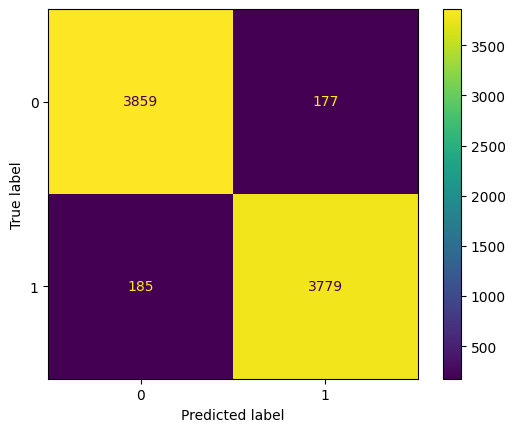

In [9]:
threshold = 0.5
preds = [0 if x < threshold else 1 for x in prediction]
cm = confusion_matrix(actual, preds)
ConfusionMatrixDisplay(cm).plot()

To evaluate this model, we shall use Mathews Correlation Coefficient. The formula for which is as follows:
$$
\frac{TP\times TN - FP\times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
$$

In [10]:
precision = cm[1, 1]/(cm[0, 1] + cm[1, 1])
recall = cm[1,1]/(cm[1,0]+cm[1,1])
true_positive = cm[1, 1]
true_negative = cm[0, 0]
false_positive = cm[0, 1]
false_negative = cm[1, 0]
mcc = (true_positive*true_negative-false_positive*false_negative)/(((true_positive+false_positive)*(true_positive+false_negative)*(true_negative+false_positive)*(true_negative+false_negative))**0.5)
f1 = 2*precision*recall/(precision+recall)
print('The Mathews Correlation coefficient is {}'.format(mcc))
print('The F1 Score is {}'.format(f1))

The Mathews Correlation coefficient is 0.909492858960672
The F1 Score is 0.9542929292929293


In [17]:
# Saving encoded words
import pickle

with open('word_bank.pkl', 'wb') as f:
    pickle.dump(memo, f)